In [1]:
# ! pip install pymongo spicy
# ! pip install matplotlib seaborn pandas numpy
# ! pip install pingouin
# ! pip install spicy krippendorff 

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import bson, json
from datetime import datetime
from collections import defaultdict
from pingouin import reliability
from scipy.stats import shapiro, f_oneway, ttest_ind
import krippendorff as kd


c:\Users\Nguyet Ha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Nguyet Ha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Descriptive Statisctic

## Method definition

In [3]:
# Convert bson file to dataframe
def bson_to_dataframe(filename):
    with open(f'./bson/{filename}.bson', 'rb') as f:
        data = bson.decode_all(f.read())
        df = pd.DataFrame(data)
    return df

In [4]:
# Convert json file to dataframe
def json_to_dataframe(filename):
    with open(f'./json/{filename}.json', 'rb') as f:
        data = json.load(f)
        df = pd.DataFrame(data)
    return df

In [5]:
# Calculate duration 
'''
Title: Calculate Time Difference Between Two Pandas Columns in Hours and Minutes
Author: cottontail
Date: Feb 16, 2023
Availability: https://stackoverflow.com/questions/22923775/calculate-time-difference-between-two-pandas-columns-in-hours-and-minutes
'''
def cal_total_time(start_time, end_time):
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    duration = end_time - start_time
    duration_readable = "{:02}:{:02}:{:02}".format(int(duration.seconds / 3600), int((duration.seconds % 3600) / 60), int(duration.seconds % 60))

    return duration_readable

In [6]:
# Extract results of surveys
def extract_survey_results(dataframe):
    results = dataframe['results']

    '''
    Title: Convert Pandas Series to Dict in Python (with code)
    Author: Riddhima Agarwal
    Date: Jun 10, 2023
    Availability: https://favtutor.com/blogs/pandas-series-to-dict#:~:text=A%20Pandas%20Series%20can%20be,the%20Pandas%20Series%20as%20values
    '''
    results_list = results.to_list()
    results_df = pd.DataFrame(results_list)

    dataframe_joined = dataframe.join(results_df)
    columns = ['_id', 'results', 'createdAt', 'updatedAt', '__v']
    dataframe = dataframe_joined.drop(columns=columns, axis=1)

    return dataframe

In [7]:
'''
Title: Inter-rater reliability calculation for multi-raters data
Author: DieseRobin
Date: Nov 25, 2021
Availability: https://stackoverflow.com/questions/56481245/inter-rater-reliability-calculation-for-multi-raters-data
'''
def cal_kippendorf_alpha(df, col):
    matrix = df.pivot(index='user_id', columns='task_id', values=col).values.astype(int)
    alpha = kd.alpha(matrix, level_of_measurement='nominal')
    return alpha

In [8]:
# Draw heatmap to show level of familiarity, complexity and satisfaction for each user and task
def draw_heatmap(df, selected_column, cmap):
    heatmap_data = df.pivot_table(index='user_id', columns='task_id', values=selected_column, fill_value=0)

    plt.figure(figsize=(6, 3))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=cmap, linewidths=.5)
    plt.title(f'{selected_column} heatmap')
    plt.xlabel('Task ID')
    plt.ylabel('User ID')
    plt.savefig(f'plot_output/{selected_column}_heatmap.jpg')

## Data Exploration

In [9]:
users_df = bson_to_dataframe("users")
prestudies_df = bson_to_dataframe("prestudies")
pretasks_df = bson_to_dataframe("pretasks")
sessions_df = bson_to_dataframe("sessions")
searchinteractions_df = bson_to_dataframe("searchinteractions")
documents_df = bson_to_dataframe("documents")
chatinteractions_df = bson_to_dataframe("chatinteractions")
posttasks_df = bson_to_dataframe("posttasks")
poststudies_df = bson_to_dataframe("poststudies")

tasks_df = json_to_dataframe("tasks")

In [10]:
users_df['study_total_time'] = users_df.apply(lambda row: cal_total_time(row['study_start_time'], row['study_end_time']), axis=1)
users_df = users_df[['user_id', 'study_total_time']]
users_df

,user_id,study_total_time
0,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,00:11:21
1,e0711a26-c616-463c-9b05-f0afaf871f31,01:23:42
2,15c09788-9078-4e28-9ec0-91d634c5b9ca,00:30:51
3,34f7c191-ff70-407c-b818-49e35cbb068f,00:15:01
4,2fbf76df-1101-4ac6-b75b-f49df2266232,00:32:11
5,fe53df51-c33e-4114-986c-c9efcca99259,00:38:17
6,525d6692-2c89-4871-b945-28f5d35a789b,00:10:58
7,d235cab9-2a67-4667-8857-a51566cffaf7,00:18:22
8,7c2b4159-df97-40a1-8376-23df2a4711ba,00:35:29
9,d80ef3e3-ebb7-40a5-9ce1-812e754809aa,00:51:39


Clean data to avoid bias

In [11]:
# filter only data of people who did the entire study
def filter_users(df):
    df = df[df['user_id'].isin(users_df['user_id'])]
    return df

In [12]:
prestudies_df = filter_users(prestudies_df)
pretasks_df = filter_users(pretasks_df)
sessions_df = filter_users(sessions_df)
searchinteractions_df = filter_users(searchinteractions_df)
chatinteractions_df = filter_users(chatinteractions_df)
posttasks_df = filter_users(posttasks_df)
poststudies_df = filter_users(poststudies_df)

documents_df = documents_df[documents_df['interaction_id'].isin(searchinteractions_df['interaction_id'])]

### Data Analysis

### a. Survey Data

#### 1. System experience

In [13]:
prestudies_df = extract_survey_results(prestudies_df)
prestudies_df

,user_id,search-engine-usage,Ai-copilots-usage,onl-search-freq,ai-search-freq
0,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,6,4,Once per day,Once per week
1,e0711a26-c616-463c-9b05-f0afaf871f31,7,5,Multiple times per day,Multiple times per week
2,15c09788-9078-4e28-9ec0-91d634c5b9ca,7,2,Multiple times per day,Once per week
3,34f7c191-ff70-407c-b818-49e35cbb068f,7,6,Multiple times per day,Once per day
4,2fbf76df-1101-4ac6-b75b-f49df2266232,7,7,Multiple times per day,Multiple times per day
5,fe53df51-c33e-4114-986c-c9efcca99259,7,7,Multiple times per day,Multiple times per day
6,525d6692-2c89-4871-b945-28f5d35a789b,7,6,Multiple times per day,Once per day
7,d235cab9-2a67-4667-8857-a51566cffaf7,7,1,Multiple times per day,Never
8,7c2b4159-df97-40a1-8376-23df2a4711ba,6,6,Multiple times per day,Multiple times per week
9,d80ef3e3-ebb7-40a5-9ce1-812e754809aa,7,5,Multiple times per week,Multiple times per week


In [14]:
prestudies_alpha = reliability.cronbach_alpha(data=prestudies_df[['search-engine-usage', 'Ai-copilots-usage']])
prestudies_alpha

(-0.06504065040650353, array([-2.959,  0.713]))

In [15]:
df = prestudies_df[['user_id', 'onl-search-freq', 'ai-search-freq']]
df

,user_id,onl-search-freq,ai-search-freq
0,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,Once per day,Once per week
1,e0711a26-c616-463c-9b05-f0afaf871f31,Multiple times per day,Multiple times per week
2,15c09788-9078-4e28-9ec0-91d634c5b9ca,Multiple times per day,Once per week
3,34f7c191-ff70-407c-b818-49e35cbb068f,Multiple times per day,Once per day
4,2fbf76df-1101-4ac6-b75b-f49df2266232,Multiple times per day,Multiple times per day
5,fe53df51-c33e-4114-986c-c9efcca99259,Multiple times per day,Multiple times per day
6,525d6692-2c89-4871-b945-28f5d35a789b,Multiple times per day,Once per day
7,d235cab9-2a67-4667-8857-a51566cffaf7,Multiple times per day,Never
8,7c2b4159-df97-40a1-8376-23df2a4711ba,Multiple times per day,Multiple times per week
9,d80ef3e3-ebb7-40a5-9ce1-812e754809aa,Multiple times per week,Multiple times per week


In [16]:
SE_freq = df.groupby(['onl-search-freq']).size().reset_index(name='count')
SE_freq 

,onl-search-freq,count
0,Multiple times per day,9
1,Multiple times per week,1
2,Once per day,1


In [17]:
AI_freq = df.groupby(['ai-search-freq']).size().reset_index(name='count')
AI_freq 

,ai-search-freq,count
0,Multiple times per day,2
1,Multiple times per week,3
2,Never,2
3,Once per day,2
4,Once per week,2


#### 2. Pre-Task Data Analysis

In [18]:
pretasks_df = extract_survey_results(pretasks_df)
pretasks_df.head(10)

,user_id,task_id,familiarity,complexity
0,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task1,3,3
1,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task2,1,5
2,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task4,3,6
3,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task3,4,5
4,e0711a26-c616-463c-9b05-f0afaf871f31,task2,4,2
5,e0711a26-c616-463c-9b05-f0afaf871f31,task3,5,4
6,e0711a26-c616-463c-9b05-f0afaf871f31,task1,3,3
7,e0711a26-c616-463c-9b05-f0afaf871f31,task4,2,5
8,15c09788-9078-4e28-9ec0-91d634c5b9ca,task3,7,2
9,15c09788-9078-4e28-9ec0-91d634c5b9ca,task4,7,2


2.1 Familiarity

In [19]:
familiarity_alpha = cal_kippendorf_alpha(pretasks_df, 'familiarity')
familiarity_alpha

0.08405612244897964

2.2 Pre complexity ratings

In [20]:
pre_complexity_alpha = cal_kippendorf_alpha(pretasks_df, 'complexity')
pre_complexity_alpha

-0.006382978723404209

2.3 Visualization

In [21]:
# familiarity_heatmap = draw_heatmap(df=pretasks_df, selected_column='familiarity', cmap='YlGnBu')

In [22]:
# pre_complexity_heatmap = draw_heatmap(df=pretasks_df, selected_column='complexity', cmap='BuPu')

#### 3. Post-Task Data Analysis

In [23]:
posttasks_df = extract_survey_results(posttasks_df)
posttasks_df.head(10)

,user_id,task_id,answer,complexity-rate,result-system,satisfaction-rate,attention
0,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task1,Unhealthy Lifestyle e.g. Smoking and excessive...,3,Generative AI (ChatGPT),6,Okay
1,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task2,"Solenopsis invicta, also known as the red impo...",2,Generative AI (ChatGPT),7,Okay
2,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task4,1. Cost: Conventional methods of home heating ...,3,Generative AI (ChatGPT),5,Okay
3,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task3,Some food additives that may pose a risk to ph...,3,Generative AI (ChatGPT),7,Okay
4,e0711a26-c616-463c-9b05-f0afaf871f31,task2,Solenopsis invicta,2,Both Google and ChatGPT,6,Okay
5,e0711a26-c616-463c-9b05-f0afaf871f31,task3,1. Artificial sweeteners\n2. Sodium nitrate an...,5,Generative AI (ChatGPT),5,Okay
6,e0711a26-c616-463c-9b05-f0afaf871f31,task1,"Many factors can affect blood pressure, includ...",4,Normal search engine (Google),5,Okay
7,e0711a26-c616-463c-9b05-f0afaf871f31,task4,1. Cost\n2. Energy Efficiency\n3. Environmenta...,5,Both Google and ChatGPT,5,Okay
8,15c09788-9078-4e28-9ec0-91d634c5b9ca,task3,Every food combines of many nutrients. It is t...,2,Normal search engine (Google),4,Okay
9,15c09788-9078-4e28-9ec0-91d634c5b9ca,task4,It depends on your demand. Fossil are cheaper ...,3,Generative AI (ChatGPT),5,Okay


3.1 Task complexity ratings

In [24]:
post_complexity_alpha = cal_kippendorf_alpha(posttasks_df, 'complexity-rate')
post_complexity_alpha

-0.023291139240506187

3.2 Satisfaction ratings

In [25]:
satisfaction_alpha = cal_kippendorf_alpha(posttasks_df, 'satisfaction-rate')
satisfaction_alpha

-0.004558404558404172

3.3 Visualization

In [26]:
# post_complexity_heatmap = draw_heatmap(df=posttasks_df, selected_column='complexity-rate', cmap='Blues')

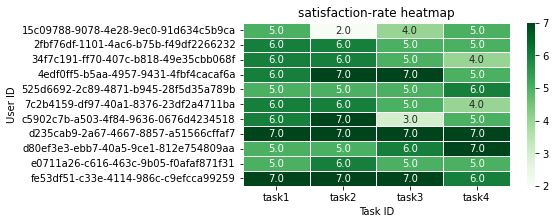

In [27]:
satisfaction_heatmap = draw_heatmap(df=posttasks_df, selected_column='satisfaction-rate', cmap='Greens')

##### 3.3 Answers for evaluation

In [28]:
answers_data = posttasks_df[['user_id', 'task_id', 'answer']]
answers_data.head(10)

,user_id,task_id,answer
0,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task1,Unhealthy Lifestyle e.g. Smoking and excessive...
1,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task2,"Solenopsis invicta, also known as the red impo..."
2,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task4,1. Cost: Conventional methods of home heating ...
3,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task3,Some food additives that may pose a risk to ph...
4,e0711a26-c616-463c-9b05-f0afaf871f31,task2,Solenopsis invicta
5,e0711a26-c616-463c-9b05-f0afaf871f31,task3,1. Artificial sweeteners\n2. Sodium nitrate an...
6,e0711a26-c616-463c-9b05-f0afaf871f31,task1,"Many factors can affect blood pressure, includ..."
7,e0711a26-c616-463c-9b05-f0afaf871f31,task4,1. Cost\n2. Energy Efficiency\n3. Environmenta...
8,15c09788-9078-4e28-9ec0-91d634c5b9ca,task3,Every food combines of many nutrients. It is t...
9,15c09788-9078-4e28-9ec0-91d634c5b9ca,task4,It depends on your demand. Fossil are cheaper ...


In [29]:
# get the answer for task 3 of user 1 
filtered_data = answers_data[(answers_data['user_id'] == '4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a') & (answers_data['task_id'] == 'task3')]
answer = filtered_data['answer'].values[0] if not filtered_data.empty else None
answer

'Some food additives that may pose a risk to physical health include:\n\n1. Artificial colors: Some artificial colors, such as Red 40 and Yellow 6, have been linked to behavioral issues and hyperactivity in children.\n\n2. Artificial sweeteners: Sweeteners like aspartame and saccharin have been associated with negative health effects, including headaches, digestive issues, and potential links to cancer.\n\n3. Preservatives: Preservatives like sodium nitrate and sulfites have been linked to allergies, asthma, and other adverse reactions in some individuals.\n\n4. Trans fats: Hydrogenated oils, which contain trans fats, have been linked to an increased risk of heart disease and other chronic health conditions.\n\n5. MSG (monosodium glutamate): This flavor enhancer has been linked to headaches, sweating, and other symptoms in some individuals.\n\nThese additives are likely to be listed on grocery store labels under their specific names or as part of a broader category (e.g. "artificial co

#### 4 Demographic Data

In [30]:
poststudies_df = extract_survey_results(poststudies_df)
poststudies_df

,user_id,gender,age,qualification,occupation,enjoy,Vp-stunden,matrikel-nr
0,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,Male,23,High school diploma or equivalent degree,Student,Bassd scho,False,NaN
1,e0711a26-c616-463c-9b05-f0afaf871f31,Female,25,High school diploma or equivalent degree,Student,Yes,False,NaN
2,15c09788-9078-4e28-9ec0-91d634c5b9ca,Male,23,Bachelor’s degree,Working,Yes,False,NaN
3,34f7c191-ff70-407c-b818-49e35cbb068f,Female,24,High school diploma or equivalent degree,Student and working,Yes :),True,"Elina Maier, 2162667"
4,2fbf76df-1101-4ac6-b75b-f49df2266232,Female,23,High school diploma or equivalent degree,Student,"Yes, it was a pleasure to be a part of the exp...",False,NaN
5,fe53df51-c33e-4114-986c-c9efcca99259,Female,28,Bachelor’s degree,Student,loved it! ;),False,NaN
6,525d6692-2c89-4871-b945-28f5d35a789b,Male,24,High school diploma or equivalent degree,Studen & Freelancer,"Yes, i think its a nice study. I liked the UI ...",True,2208194
7,d235cab9-2a67-4667-8857-a51566cffaf7,Female,25,Bachelor’s degree,Student,Yes,True,Mai Phuong Ngo - 3286779
8,7c2b4159-df97-40a1-8376-23df2a4711ba,Female,24,Bachelor’s degree,Working,Yes,False,NaN
9,d80ef3e3-ebb7-40a5-9ce1-812e754809aa,Female,24,Bachelor’s degree,Working,Yes a lot,False,NaN


In [31]:
def count_gender(df):
    gender_counts = {}
    for gender in df['gender']:
        if gender in gender_counts:
            gender_counts[gender] += 1
        else:
            gender_counts[gender] = 1

    # Displaying the counts
    print("Count of each gender type:")
    for gender, count in gender_counts.items():
        print(f"{gender}: {count}")

In [32]:
def cal_mean_age(df):
    ages = df['age']
    mean_age = np.mean(ages)
    print(f"Mean age: {mean_age:0.2f}")

In [33]:
count_gender(poststudies_df)

Count of each gender type:
Male: 4
Female: 7


In [34]:
cal_mean_age(poststudies_df)

Mean age: 24.73


In [35]:
# filter only participants who need VP-Stunden
VP_data = poststudies_df[(poststudies_df['Vp-stunden'] == True)]
matrikel_nr_list = VP_data['matrikel-nr']
matrikel_nr_list

'''
Title: Writing a list to a file with Python, with newlines
Author: Alex Martelli
Date: May 22, 2009
Availability: https://stackoverflow.com/questions/899103/writing-a-list-to-a-file-with-python-with-newlines
'''
with open('matrikel_nr_list.txt', 'w') as f:
    for line in matrikel_nr_list:
        f.write(f"{line}\n")

### b. Interaction Data 

In [36]:
tasks_df.rename(columns={'id':'task_id'}, inplace=True)
tasks_df

,title,category,desc,task_id
0,Task 1:,simple,Your brother complains of constant headaches. ...,task1
1,Task 2:,simple,A friend has just sent an email from an Intern...,task2
2,Task 3:,complex,"You recently heard about the book ""Fast Food N...",task3
3,Task 4:,complex,Friends are planning to build a new house and ...,task4


In [37]:
sessions_df['session_total_time'] = sessions_df.apply(lambda row: cal_total_time(row['session_start_time'], row['session_end_time']), axis=1)
columns = ['_id', '__v', 'session_start_time', 'session_end_time']
sessions_df = sessions_df.drop(columns=columns, axis=1)

In [38]:
sessions_df

,session_id,user_id,task_id,session_total_time
0,a27bf979-97ed-489d-8dcd-cd1dfb4fc0ab,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task1,00:01:46
1,cc13e90f-8d51-4686-9580-8b18b56f7802,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task2,00:01:02
2,02e846b3-55dc-4713-a2d8-f144295d2657,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task4,00:01:08
3,f78d2301-5d15-4393-a778-d04276901baa,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task3,00:00:44
4,26dcc03b-a604-4d6c-9c01-cc072cb18e31,e0711a26-c616-463c-9b05-f0afaf871f31,task2,00:01:34
5,c028d42f-a486-4837-820b-09d11907e677,e0711a26-c616-463c-9b05-f0afaf871f31,task3,00:03:25
6,70a21323-dfc8-4d81-ace2-c43dd72c6be9,e0711a26-c616-463c-9b05-f0afaf871f31,task1,00:09:26
7,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,e0711a26-c616-463c-9b05-f0afaf871f31,task4,00:05:52
8,77b27376-0bc9-427f-97ac-a13a6974e6da,15c09788-9078-4e28-9ec0-91d634c5b9ca,task3,00:05:16
9,c9c2a626-e7e3-4ac8-bfb9-33eef5cec0cd,15c09788-9078-4e28-9ec0-91d634c5b9ca,task4,00:05:29


##### 1. Time overall

In [39]:
sessions_merged_df= pd.merge(sessions_df, tasks_df, on='task_id', how='left')
sessions_merged_df = sessions_merged_df.drop(['title', 'desc'], axis=1)

In [40]:
sessions_merged_df 

,session_id,user_id,task_id,session_total_time,category
0,a27bf979-97ed-489d-8dcd-cd1dfb4fc0ab,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task1,00:01:46,simple
1,cc13e90f-8d51-4686-9580-8b18b56f7802,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task2,00:01:02,simple
2,02e846b3-55dc-4713-a2d8-f144295d2657,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task4,00:01:08,complex
3,f78d2301-5d15-4393-a778-d04276901baa,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,task3,00:00:44,complex
4,26dcc03b-a604-4d6c-9c01-cc072cb18e31,e0711a26-c616-463c-9b05-f0afaf871f31,task2,00:01:34,simple
5,c028d42f-a486-4837-820b-09d11907e677,e0711a26-c616-463c-9b05-f0afaf871f31,task3,00:03:25,complex
6,70a21323-dfc8-4d81-ace2-c43dd72c6be9,e0711a26-c616-463c-9b05-f0afaf871f31,task1,00:09:26,simple
7,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,e0711a26-c616-463c-9b05-f0afaf871f31,task4,00:05:52,complex
8,77b27376-0bc9-427f-97ac-a13a6974e6da,15c09788-9078-4e28-9ec0-91d634c5b9ca,task3,00:05:16,complex
9,c9c2a626-e7e3-4ac8-bfb9-33eef5cec0cd,15c09788-9078-4e28-9ec0-91d634c5b9ca,task4,00:05:29,complex


In [41]:
task_time_df = sessions_merged_df[['task_id', 'session_total_time']]
task_time_df

,task_id,session_total_time
0,task1,00:01:46
1,task2,00:01:02
2,task4,00:01:08
3,task3,00:00:44
4,task2,00:01:34
5,task3,00:03:25
6,task1,00:09:26
7,task4,00:05:52
8,task3,00:05:16
9,task4,00:05:29


In [42]:
# calculate the overall time for each task
def cal_time_each_task(dataframe):
    task_time_list = dataframe.to_dict('records')

    task_time_dict = {}

    for entry in task_time_list:
        task_id = entry["task_id"]
        session_time = datetime.strptime(entry["session_total_time"], "%H:%M:%S")
        if task_id in task_time_dict:
            task_time_dict[task_id] += session_time - datetime(1900, 1, 1)
        else:
            task_time_dict[task_id] = session_time - datetime(1900, 1, 1)

    return task_time_dict

In [43]:
# Visualization using horizontal bar chart
'''
Title: Bar Plot in Matplotlib
Author: jeeteshgavand
Date: 04 Mar, 2021
Availability: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
'''
def visualize_time_each_task(task_time_dict):
    # Figure Size
    fig, ax = plt.subplots(figsize =(8, 3))
    
    task_overalltime_minutes = {key: value.total_seconds()/60 for key, value in task_time_dict.items()}

    tasks = list(task_overalltime_minutes.keys())
    minutes = list(task_overalltime_minutes.values())
    # Horizontal Bar Plot
    ax.barh(tasks, minutes)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    
    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    
    # Show top values 
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5, 
                str(round((i.get_width()), 2)),
                fontsize = 10, fontweight ='bold',
                color ='grey')
    
        # Adding labels and title
    ax.set_xlabel('Minutes')
    ax.set_title('Overall Time for each Task',
                loc ='left', )
    ax.figure.savefig("plot_output/Overall_Time_each_Task.jpg")

In [44]:
# Visualization using vertical bar chart
def visualize_overalltime(task_time_dict): 
    simple_tasks_overalltime = (task_time_dict['task1'] + task_time_dict['task2']).total_seconds()/60
    complex_tasks_overalltime =(task_time_dict['task3'] + task_time_dict['task4']).total_seconds()/60

    # Data for plotting
    tasks = ['Simple Tasks', 'Complex Tasks']
    times = [simple_tasks_overalltime, complex_tasks_overalltime]

    fig = plt.figure(figsize = (5, 3))

    # Plotting the bar chart
    plt.bar(tasks, times, color ='maroon')

    # Adding labels and title
    plt.xlabel('Task Type')
    plt.ylabel('Overall Time (minutes)')
    plt.title('Overall Time for Simple vs Complex Tasks')
    plt.savefig("plot_output/overalltime.jpg")

In [45]:
# calculate the overall time for each type of tasks
def print_overalltime(task_time_dict):
    
    # Convert total times to string format
    simple_tasks_overalltime = str(task_time_dict['task1'] + task_time_dict['task2'])
    complex_tasks_overalltime = str(task_time_dict['task3'] + task_time_dict['task4'])

    for task_id, total_time in task_time_dict.items():
        task_time_dict[task_id] = str(total_time)

    # print overalltime
    print("Overall time for each task:")
    for task_id, total_time in task_time_dict.items():
        print(f"{task_id}: {total_time}")

    print('Overall time for simple tasks: ' + simple_tasks_overalltime)
    print('Overall time for complex tasks: ' + complex_tasks_overalltime)

Overall time for each task:
task1: 0:32:22
task2: 0:25:00
task4: 0:51:29
task3: 0:43:36
Overall time for simple tasks: 0:57:22
Overall time for complex tasks: 1:35:05


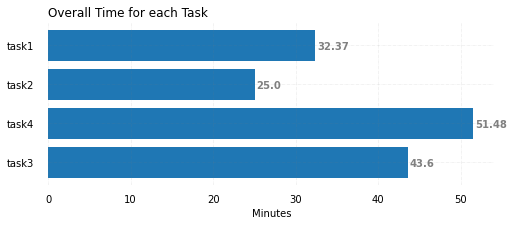

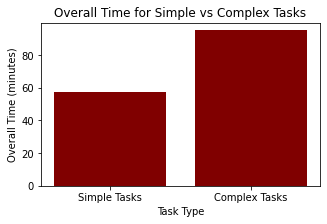

In [46]:
task_overalltime = cal_time_each_task(task_time_df)
visualize_time_each_task(task_overalltime)
visualize_overalltime(task_overalltime)
print_overalltime(task_overalltime)

##### 2. Queries

2.1. Search Queries

In [47]:
# Count number of queries each task when interacting with SE or Chat
def count_queries_each_task(dict):
    queries_counts = defaultdict(int)

    for item in dict:
        queries_counts[item['task_id']] += 1

    return queries_counts

In [48]:
task_session_df = sessions_merged_df[['session_id', 'task_id']]
task_session_df 

,session_id,task_id
0,a27bf979-97ed-489d-8dcd-cd1dfb4fc0ab,task1
1,cc13e90f-8d51-4686-9580-8b18b56f7802,task2
2,02e846b3-55dc-4713-a2d8-f144295d2657,task4
3,f78d2301-5d15-4393-a778-d04276901baa,task3
4,26dcc03b-a604-4d6c-9c01-cc072cb18e31,task2
5,c028d42f-a486-4837-820b-09d11907e677,task3
6,70a21323-dfc8-4d81-ace2-c43dd72c6be9,task1
7,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,task4
8,77b27376-0bc9-427f-97ac-a13a6974e6da,task3
9,c9c2a626-e7e3-4ac8-bfb9-33eef5cec0cd,task4


In [49]:
cols = ['_id', '__v', 'createdAt', 'updatedAt']
searchinteractions_df = searchinteractions_df.drop(columns=cols, axis=1)
documents_df = documents_df.drop(columns=cols, axis=1)

In [50]:
googlesearch_merged_df = pd.merge(searchinteractions_df, task_session_df, on='session_id', how='inner')
googlesearch_merged_df.head(10)

,interaction_id,user_id,session_id,interaction_type,query,number_of_retrieved_docs,task_id
0,dcb1798d-2140-4b78-bae0-5e2d6808199c,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,a27bf979-97ed-489d-8dcd-cd1dfb4fc0ab,google,high blood pressure cause,"645,000,000",task1
1,dcb1798d-2140-4b78-bae0-5e2d6808199c,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,a27bf979-97ed-489d-8dcd-cd1dfb4fc0ab,google,high blood pressure cause,"645,000,000",task1
2,87a4d351-4a6e-4297-a71f-f474e52524c4,e0711a26-c616-463c-9b05-f0afaf871f31,26dcc03b-a604-4d6c-9c01-cc072cb18e31,google,name the small red ant spiecies that bite,"11,700,000",task2
3,87a4d351-4a6e-4297-a71f-f474e52524c4,e0711a26-c616-463c-9b05-f0afaf871f31,26dcc03b-a604-4d6c-9c01-cc072cb18e31,google,name the small red ant spiecies that bite,"18,800,000",task2
4,87a4d351-4a6e-4297-a71f-f474e52524c4,e0711a26-c616-463c-9b05-f0afaf871f31,26dcc03b-a604-4d6c-9c01-cc072cb18e31,google,name the small red ant spiecies that bite,"18,500,000",task2
5,be9ee781-7a82-4e58-95d3-8e0752ef8b1a,e0711a26-c616-463c-9b05-f0afaf871f31,c028d42f-a486-4837-820b-09d11907e677,google,food additives pose a risk to your physical he...,"20,300,000",task3
6,d5ad368c-ec73-4e18-855c-4abd9c52f6a8,e0711a26-c616-463c-9b05-f0afaf871f31,70a21323-dfc8-4d81-ace2-c43dd72c6be9,google,cause of high blood pressure with headaches an...,"91,900,000",task1
7,27b20136-f946-4c3b-be3c-63f8da9c4e46,e0711a26-c616-463c-9b05-f0afaf871f31,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,google,issues that need to be considered in deciding...,"15,800,000",task4
8,27b20136-f946-4c3b-be3c-63f8da9c4e46,e0711a26-c616-463c-9b05-f0afaf871f31,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,google,fossil energy sources and solar panels.,"90,800,000",task4
9,d3a83791-412f-4933-9352-0a1db2f4a7fd,15c09788-9078-4e28-9ec0-91d634c5b9ca,77b27376-0bc9-427f-97ac-a13a6974e6da,google,best food for physical health,"1,250,000,000",task3


In [51]:
task_queries_SE_df = googlesearch_merged_df[['query', 'task_id']]
task_queries_SE_df

,query,task_id
0,high blood pressure cause,task1
1,high blood pressure cause,task1
2,name the small red ant spiecies that bite,task2
3,name the small red ant spiecies that bite,task2
4,name the small red ant spiecies that bite,task2
5,food additives pose a risk to your physical he...,task3
6,cause of high blood pressure with headaches an...,task1
7,issues that need to be considered in deciding...,task4
8,fossil energy sources and solar panels.,task4
9,best food for physical health,task3


In [52]:
task_queries_SE_dict = task_queries_SE_df.to_dict('records')
task_queries_SE_dict

[{'query': 'high blood pressure cause', 'task_id': 'task1'},
 {'query': 'high blood pressure cause', 'task_id': 'task1'},
 {'query': 'name the small red ant spiecies that bite', 'task_id': 'task2'},
 {'query': 'name the small red ant spiecies that bite', 'task_id': 'task2'},
 {'query': 'name the small red ant spiecies that bite', 'task_id': 'task2'},
 {'query': 'food additives pose a risk to your physical health',
  'task_id': 'task3'},
 {'query': 'cause of high blood pressure with headaches and nausea',
  'task_id': 'task1'},
 {'query': ' issues that need to be considered in deciding between more conventional methods of home heating (fossil energy sources) and solar panels.',
  'task_id': 'task4'},
 {'query': 'fossil energy sources and solar panels.', 'task_id': 'task4'},
 {'query': 'best food for physical health', 'task_id': 'task3'},
 {'query': 'best food for physical health', 'task_id': 'task3'},
 {'query': 'unexpected unhealth food', 'task_id': 'task3'},
 {'query': 'what are best 

2.2. Chat Queries

In [53]:
chatinteractions_df = chatinteractions_df[['user_id', 'session_id', 'interaction_type', 'messages']]
chatinteractions_df

,user_id,session_id,interaction_type,messages
0,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,a27bf979-97ed-489d-8dcd-cd1dfb4fc0ab,openai,None
1,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,cc13e90f-8d51-4686-9580-8b18b56f7802,openai,[[{'text': 'name one small red ant species in ...
2,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,02e846b3-55dc-4713-a2d8-f144295d2657,openai,[[{'text': 'what are issues that need to be co...
3,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,f78d2301-5d15-4393-a778-d04276901baa,openai,[[{'text': 'which food additives pose a risk t...
4,e0711a26-c616-463c-9b05-f0afaf871f31,26dcc03b-a604-4d6c-9c01-cc072cb18e31,openai,[[{'text': 'name the small red ant spiecies th...
5,e0711a26-c616-463c-9b05-f0afaf871f31,c028d42f-a486-4837-820b-09d11907e677,openai,[[{'text': 'food additives pose a risk to your...
6,e0711a26-c616-463c-9b05-f0afaf871f31,70a21323-dfc8-4d81-ace2-c43dd72c6be9,openai,[[{'text': 'my brother has constant headaches....
7,e0711a26-c616-463c-9b05-f0afaf871f31,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,openai,[[{'text': ' issues that need to be considered...
8,15c09788-9078-4e28-9ec0-91d634c5b9ca,77b27376-0bc9-427f-97ac-a13a6974e6da,openai,[[{'text': 'i found a list of healthy/unhealth...
9,15c09788-9078-4e28-9ec0-91d634c5b9ca,c9c2a626-e7e3-4ac8-bfb9-33eef5cec0cd,openai,[[{'text': 'what are best option for nowsaday ...


In [54]:
chat_merged_df = pd.merge(chatinteractions_df, task_session_df, on='session_id', how='inner')
chat_merged_df.head(10)

,user_id,session_id,interaction_type,messages,task_id
0,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,a27bf979-97ed-489d-8dcd-cd1dfb4fc0ab,openai,None,task1
1,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,cc13e90f-8d51-4686-9580-8b18b56f7802,openai,[[{'text': 'name one small red ant species in ...,task2
2,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,02e846b3-55dc-4713-a2d8-f144295d2657,openai,[[{'text': 'what are issues that need to be co...,task4
3,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,f78d2301-5d15-4393-a778-d04276901baa,openai,[[{'text': 'which food additives pose a risk t...,task3
4,e0711a26-c616-463c-9b05-f0afaf871f31,26dcc03b-a604-4d6c-9c01-cc072cb18e31,openai,[[{'text': 'name the small red ant spiecies th...,task2
5,e0711a26-c616-463c-9b05-f0afaf871f31,c028d42f-a486-4837-820b-09d11907e677,openai,[[{'text': 'food additives pose a risk to your...,task3
6,e0711a26-c616-463c-9b05-f0afaf871f31,70a21323-dfc8-4d81-ace2-c43dd72c6be9,openai,[[{'text': 'my brother has constant headaches....,task1
7,e0711a26-c616-463c-9b05-f0afaf871f31,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,openai,[[{'text': ' issues that need to be considered...,task4
8,15c09788-9078-4e28-9ec0-91d634c5b9ca,77b27376-0bc9-427f-97ac-a13a6974e6da,openai,[[{'text': 'i found a list of healthy/unhealth...,task3
9,15c09788-9078-4e28-9ec0-91d634c5b9ca,c9c2a626-e7e3-4ac8-bfb9-33eef5cec0cd,openai,[[{'text': 'what are best option for nowsaday ...,task4


In [55]:
def extract_chat_queries():  
    task_query_AI_dict = chat_merged_df[['messages', 'task_id']].to_dict() 
    extracted_data = []
    for key, value in task_query_AI_dict['messages'].items():
        if value is not None:
            for task_id, sublist in enumerate(value):
                for message in sublist:
                    if not message['isBot']:
                        extracted_data.append({'task_id': task_query_AI_dict['task_id'][key], 'query': message['text']})
    return extracted_data

In [56]:
task_queries_AI_dict = extract_chat_queries()
task_queries_AI_dict

[{'task_id': 'task2',
  'query': 'name one small red ant species in the southern usa'},
 {'task_id': 'task4',
  'query': 'what are issues that need to be considered in deciding between  conventional methods of home heating (fossil energy sources) and solar panels'},
 {'task_id': 'task3',
  'query': 'which food additives pose a risk to your physical health, and are likely to be listed on grocery store labels'},
 {'task_id': 'task2', 'query': 'name the small red ant spiecies that bite\n'},
 {'task_id': 'task3',
  'query': 'food additives pose a risk to your physical health\n'},
 {'task_id': 'task3',
  'query': 'which food additives pose a risk to my physical health'},
 {'task_id': 'task1',
  'query': 'my brother has constant headaches. Tonight his headache is accompanied by nausea, and his blood pressure is 120. What causes high blood pressure?'},
 {'task_id': 'task1',
  'query': 'what about headaches with nausea and high blood pressure'},
 {'task_id': 'task4',
  'query': ' issues that n

In [57]:
task_queries_AI_df = pd.DataFrame(task_queries_AI_dict)
task_queries_AI_df 

,task_id,query
0,task2,name one small red ant species in the southern...
1,task4,what are issues that need to be considered in ...
2,task3,which food additives pose a risk to your physi...
3,task2,name the small red ant spiecies that bite\n
4,task3,food additives pose a risk to your physical he...
5,task3,which food additives pose a risk to my physica...
6,task1,my brother has constant headaches. Tonight his...
7,task1,what about headaches with nausea and high bloo...
8,task4,issues that need to be considered in deciding...
9,task3,i found a list of healthy/unhealthy food for p...


2.3. Number of queries each system

In [58]:
queries_SE_counts = count_queries_each_task(task_queries_SE_dict)
queries_SE_counts_df = pd.DataFrame(list(queries_SE_counts .items()), columns=['Task ID', 'Num Queries SE'])
queries_SE_counts_df

,Task ID,Num Queries SE
0,task1,12
1,task2,10
2,task3,17
3,task4,13


In [59]:
queries_AI_counts = count_queries_each_task(task_queries_AI_dict)
queries_AI_counts_df = pd.DataFrame(list(queries_AI_counts .items()), columns=['Task ID', 'Num Queries AI'])
queries_AI_counts_df

,Task ID,Num Queries AI
0,task2,15
1,task4,18
2,task3,15
3,task1,12


In [60]:
queries_system_df = pd.merge(queries_AI_counts_df, queries_SE_counts_df, on='Task ID', how='outer')
queries_system_df

,Task ID,Num Queries AI,Num Queries SE
0,task1,12,12
1,task2,15,10
2,task3,15,17
3,task4,18,13


2.4. Mean query length each system

In [61]:
def cal_mean_query_length (dict, system):
    # Dictionary to store total query length and count for each task
    task_lengths = defaultdict(lambda: {'total_length': 0, 'count': 0})

    # Calculate total query length and count for each task
    for query in dict:
        task_id = query['task_id']
        query_length = len(query['query'].split())  # Split query by space and count words
        task_lengths[task_id]['total_length'] += query_length
        task_lengths[task_id]['count'] += 1

    # Calculate mean query length for each task
    mean_lengths = {task_id: task_info['total_length'] / task_info['count'] for task_id, task_info in task_lengths.items()}

    df = pd.DataFrame(mean_lengths.items(), columns=['Task ID', f"Mean Length Query{system}"])
    return df

In [62]:
mean_length_queryAI_df = cal_mean_query_length(task_queries_AI_dict, "AI")
mean_length_queryAI_df

,Task ID,Mean Length QueryAI
0,task2,15.866667
1,task4,18.055556
2,task3,17.266667
3,task1,15.666667


In [63]:
mean_length_querySE_df = cal_mean_query_length(task_queries_SE_dict, "SE")
mean_length_querySE_df

,Task ID,Mean Length QuerySE
0,task1,5.416667
1,task2,11.200000
2,task3,8.882353
3,task4,21.076923


In [64]:
mean_query_length_df = pd.merge(mean_length_queryAI_df, mean_length_querySE_df, on='Task ID', how='outer')
mean_query_length_df

,Task ID,Mean Length QueryAI,Mean Length QuerySE
0,task1,15.666667,5.416667
1,task2,15.866667,11.200000
2,task3,17.266667,8.882353
3,task4,18.055556,21.076923


* Visualization 

In [65]:
# Visualization using multiple bar charts
'''
Title: Bar Plot in Matplotlib
Author: jeeteshgavand
Date: 04 Mar, 2021
Availability: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
'''
def visualize_bar_chart(df, col1, col2, ylabel): 
    barWidth = 0.25
    fig = plt.subplots(figsize =(6, 3)) 

    list1 = df[col1]
    list2 = df[col2]
    
    br1 = np.arange(len(list1)) 
    br2 = [x + barWidth for x in br1] 
    
    plt.bar(br1, list1, color ='r', width = barWidth, 
            edgecolor ='grey', label =col1) 
    plt.bar(br2, list2, color ='g', width = barWidth, 
            edgecolor ='grey', label =col2) 

    plt.xlabel('Task ID', fontsize = 15) 
    plt.ylabel( ylabel, fontsize = 15) 
    plt.xticks([r + barWidth for r in range(len(list1))], df['Task ID'])
    
    plt.legend()
    plt.savefig(f"plot_output/{ylabel}.jpg")

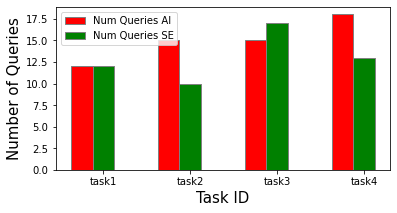

In [66]:
num_Queries_AI ='Num Queries AI'
num_Queries_SE ='Num Queries SE'
visualize_bar_chart(queries_system_df, num_Queries_AI, num_Queries_SE, "Number of Queries")

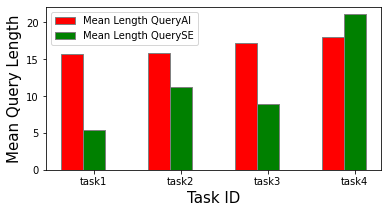

In [67]:
mean_length_AI = "Mean Length QueryAI"
mean_length_SE = "Mean Length QuerySE"
visualize_bar_chart(mean_query_length_df, mean_length_AI, mean_length_SE, "Mean Query Length")

In [68]:
# Visualize using boxplots
def visualize_boxplot(df, system):
    df['query_length'] = df['query'].apply(len)

    plt.figure(figsize=(6,3))
    df.boxplot(column='query_length', by='task_id')
    plt.title(f'Boxplot of Query Length {system} for Each Task')
    plt.xlabel('Task ID')
    plt.ylabel('Query Length')
    plt.suptitle('')
    plt.savefig(f"plot_output/query_length_{system}.jpg")

<Figure size 432x216 with 0 Axes>

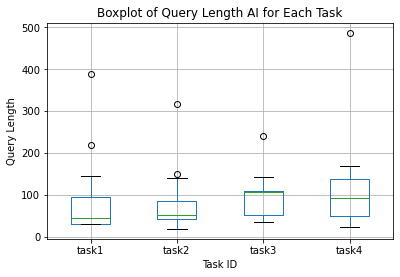

In [69]:
visualize_boxplot(task_queries_AI_df, "AI")

C:\Users\NGUYET~1\AppData\Local\Temp/ipykernel_7484/647618580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['query_length'] = df['query'].apply(len)


<Figure size 432x216 with 0 Axes>

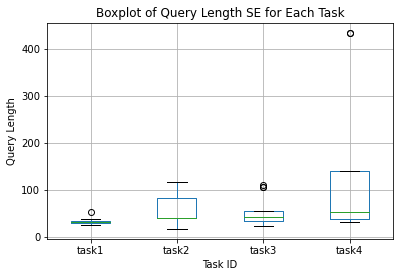

In [70]:
visualize_boxplot(task_queries_SE_df, "SE")

##### 3. Doc position analysis

In [71]:
googlesearch_docs_df = pd.merge(googlesearch_merged_df, documents_df, on='interaction_id', how='inner')
googlesearch_docs_df.head(10)

,interaction_id,user_id,session_id,interaction_type,query,number_of_retrieved_docs,task_id,doc_title,doc_position,doc_page_viewed,doc_id
0,dcb1798d-2140-4b78-bae0-5e2d6808199c,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,a27bf979-97ed-489d-8dcd-cd1dfb4fc0ab,google,high blood pressure cause,"645,000,000",task1,High blood pressure (hypertension) - Symptoms ...,1,1,NaN
1,dcb1798d-2140-4b78-bae0-5e2d6808199c,4edf0ff5-b5aa-4957-9431-4fbf4cacaf6a,a27bf979-97ed-489d-8dcd-cd1dfb4fc0ab,google,high blood pressure cause,"645,000,000",task1,High blood pressure (hypertension) - Symptoms ...,1,1,NaN
2,87a4d351-4a6e-4297-a71f-f474e52524c4,e0711a26-c616-463c-9b05-f0afaf871f31,26dcc03b-a604-4d6c-9c01-cc072cb18e31,google,name the small red ant spiecies that bite,"11,700,000",task2,"Fire ant bites: Treatment, symptoms, what they...",4,1,_C4HIP5W824J
3,87a4d351-4a6e-4297-a71f-f474e52524c4,e0711a26-c616-463c-9b05-f0afaf871f31,26dcc03b-a604-4d6c-9c01-cc072cb18e31,google,name the small red ant spiecies that bite,"18,800,000",task2,"Fire ant bites: Treatment, symptoms, what they...",4,1,_C4HIP5W824J
4,87a4d351-4a6e-4297-a71f-f474e52524c4,e0711a26-c616-463c-9b05-f0afaf871f31,26dcc03b-a604-4d6c-9c01-cc072cb18e31,google,name the small red ant spiecies that bite,"18,500,000",task2,"Fire ant bites: Treatment, symptoms, what they...",4,1,_C4HIP5W824J
5,be9ee781-7a82-4e58-95d3-8e0752ef8b1a,e0711a26-c616-463c-9b05-f0afaf871f31,c028d42f-a486-4837-820b-09d11907e677,google,food additives pose a risk to your physical he...,"20,300,000",task3,A Detailed Review Study on Potential Effects o...,1,1,NaN
6,d5ad368c-ec73-4e18-855c-4abd9c52f6a8,e0711a26-c616-463c-9b05-f0afaf871f31,70a21323-dfc8-4d81-ace2-c43dd72c6be9,google,cause of high blood pressure with headaches an...,"91,900,000",task1,High blood pressure in adults - hypertension: ...,1,1,92lx7oh0LwoJ
7,27b20136-f946-4c3b-be3c-63f8da9c4e46,e0711a26-c616-463c-9b05-f0afaf871f31,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,google,issues that need to be considered in deciding...,"15,800,000",task4,Solar Energy vs Fossil Fuels: How Do They Comp...,1,1,obBzCN408dUJ
8,27b20136-f946-4c3b-be3c-63f8da9c4e46,e0711a26-c616-463c-9b05-f0afaf871f31,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,google,issues that need to be considered in deciding...,"15,800,000",task4,Efficiency of Solar Panels compared to Fossil ...,3,1,LOC2VQtIQ_AJ
9,27b20136-f946-4c3b-be3c-63f8da9c4e46,e0711a26-c616-463c-9b05-f0afaf871f31,ab2010e6-bfb6-40a5-86af-c0fdd74c5979,google,fossil energy sources and solar panels.,"90,800,000",task4,Solar Energy vs Fossil Fuels: How Do They Comp...,1,1,obBzCN408dUJ


In [72]:
googlesearch_docs_df = googlesearch_docs_df[['task_id', 'doc_position', 'doc_page_viewed']]
googlesearch_docs_df.head(10)

,task_id,doc_position,doc_page_viewed
0,task1,1,1
1,task1,1,1
2,task2,4,1
3,task2,4,1
4,task2,4,1
5,task3,1,1
6,task1,1,1
7,task4,1,1
8,task4,3,1
9,task4,1,1


In [73]:
result_docs_pos = googlesearch_docs_df.groupby(['task_id', 'doc_position']).size().reset_index(name='count')
result_docs_pos 

,task_id,doc_position,count
0,task1,1,6
1,task1,2,2
2,task1,5,4
3,task1,7,2
4,task2,1,3
5,task2,2,2
6,task2,4,3
7,task3,1,14
8,task3,2,3
9,task3,3,4


In [74]:
result_docs_page_viewed = googlesearch_docs_df.groupby(['task_id', 'doc_page_viewed']).size().reset_index(name='count')
result_docs_page_viewed

,task_id,doc_page_viewed,count
0,task1,1,14
1,task2,1,8
2,task3,1,23
3,task4,1,12


* Visualization

In [75]:
def visualize_stackedbar(df, index): 
    pivot_df = df.pivot(index=index, columns='task_id', values='count').fillna(0)

    plt.figure(figsize=(6, 3))
    sns.set_palette("husl")
    pivot_df.plot(kind='bar', stacked=True)
    plt.xlabel(index)
    plt.ylabel('Count')
    plt.title(f'Count vs {index} for each Task')
    plt.legend(title='Task ID')
    plt.savefig(f"plot_output/count_{index}.jpg")

<Figure size 432x216 with 0 Axes>

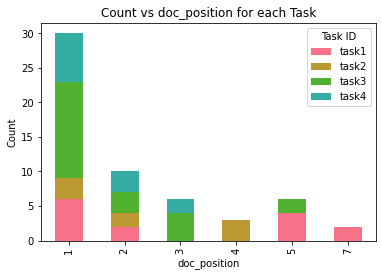

In [76]:
visualize_stackedbar(result_docs_pos, 'doc_position')

<Figure size 432x216 with 0 Axes>

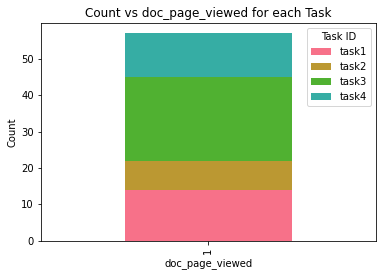

In [77]:
visualize_stackedbar(result_docs_page_viewed, 'doc_page_viewed')

# Inferential statistics

In [78]:
new_posttasks_df = pd.merge(posttasks_df, tasks_df, on="task_id", how="inner")
new_posttasks_df = new_posttasks_df[['task_id', 'result-system', 'complexity-rate', 'satisfaction-rate', 'category' ]]
new_posttasks_df

,task_id,result-system,complexity-rate,satisfaction-rate,category
0,task1,Generative AI (ChatGPT),3,6,simple
1,task2,Generative AI (ChatGPT),2,7,simple
2,task4,Generative AI (ChatGPT),3,5,complex
3,task3,Generative AI (ChatGPT),3,7,complex
4,task2,Both Google and ChatGPT,2,6,simple
5,task3,Generative AI (ChatGPT),5,5,complex
6,task1,Normal search engine (Google),4,5,simple
7,task4,Both Google and ChatGPT,5,5,complex
8,task3,Normal search engine (Google),2,4,complex
9,task4,Generative AI (ChatGPT),3,5,complex


In [79]:
h2_df = new_posttasks_df[['task_id', 'result-system', 'category']]
h2_df

,task_id,result-system,category
0,task1,Generative AI (ChatGPT),simple
1,task2,Generative AI (ChatGPT),simple
2,task4,Generative AI (ChatGPT),complex
3,task3,Generative AI (ChatGPT),complex
4,task2,Both Google and ChatGPT,simple
5,task3,Generative AI (ChatGPT),complex
6,task1,Normal search engine (Google),simple
7,task4,Both Google and ChatGPT,complex
8,task3,Normal search engine (Google),complex
9,task4,Generative AI (ChatGPT),complex
